<h1> Analysing Elon Musk's tweeting style 2015-2020

<h2> Import all necessary libraries

In [95]:
import os
import re
import nltk
import voila
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from datetime import date, datetime
from pandas_profiling import ProfileReport
from tabulate import tabulate
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from scipy import stats
from nltk.corpus import stopwords

<h2> Create the file name and path references

In [5]:
file_path_name = "elonmusk_origin.csv"

In [6]:
def open_file(file_path_name):
    """
    This function opens the csv file and creates the dataframe
    :param file_path_name: Name of the path and the input file
    :return: The pandas dataframe
    """
    return pd.read_csv(file_path_name, index_col=[0])

In [7]:
print(open_file(file_path_name).head())

                         conversation_id     created_at        date      time  \
id                                                                              
1282939902531796993  1282933079431151618  1594711683000  2020-07-14  07:28:03   
1282844872571904000  1282801938111791104  1594689026000  2020-07-14  01:10:26   
1282805559834492929  1282758532312584193  1594679653000  2020-07-13  22:34:13   
1282800187308572672  1282671714657157120  1594678372000  2020-07-13  22:12:52   
1282800078000803840  1282739486816964615  1594678346000  2020-07-13  22:12:26   

                    timezone   user_id  username       name  place  \
id                                                                   
1282939902531796993      UTC  44196397  elonmusk  Elon Musk    NaN   
1282844872571904000      UTC  44196397  elonmusk  Elon Musk    NaN   
1282805559834492929      UTC  44196397  elonmusk  Elon Musk    NaN   
1282800187308572672      UTC  44196397  elonmusk  Elon Musk    NaN   
128280007800

<h2> Create a dataframe profile pdf

In [8]:
# def profile_dataframe(file_path_name):
#     """
#     This function is taking the pandas dataframe and creating the profile report in the html format.
#     :param file_path_name: Name of the path and the input file
#     :return: The dataframe profile in the html format
#     """
#     today = date.today()
#     df = open_file(file_path_name)
#     profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
#     profile.to_file("report_{0}.html".format(today))


# open(profile_dataframe(file_path_name))

<h2> Perform the dataframe cleaning

In [9]:
def drop_columns_with_constant_values(df):
    return df.drop(columns=list(df.columns[df.nunique() <= 1]))


def check_the_head_of_constant_columns(df):
    print(tabulate
          (df[df.columns[df.nunique() <= 1]].head(20), headers='keys', tablefmt='psql'))

    
columns_to_drop = ['hashtags', 'cashtags', 'link', 'quote_url', 'urls', 'created_at']


def drop_redundant_columns(df, columns_to_drop):
    return df.drop(columns=columns_to_drop, axis=0)

<h2> Add new count columns

In [10]:
def reply_to_count(df):
    reply_to_count_values = []
    for i, content in df['reply_to'].items():
        reply_to_count_values.append((int(content.count("{")) - 1))
    df['reply_to_count'] = reply_to_count_values
    return df


def mentions_count(df):
    new_values = []
    for i, content in df['mentions'].items():
        new_values.append(int(content.count("'") / 2))
    df['mentions_count'] = new_values
    return df


def photos_count(df):
    new_values = []
    for i, content in df['photos'].items():
        new_values.append(int(content.count("https")))
    df['photos_count'] = new_values
    return df

<h2> Add new date and time related columns

In [324]:
def add_weekday(df):
    weekday = []
    for i, content in df['date'].items():
        year, month, day = map(int, content.split('-'))
        d = date(year, month, day)
        weekday.append(d.weekday())
    df['weekday'] = weekday
    return df


def convert_to_datetime(df):
    df['datetime'] = (df['date'] + " " + df['time']).astype('string')
    return df


def extract_hour_minute(df, time_column):
    year_col = []
    month_col = []
    hour_col = []
    minute_col = []
    for i, content in df['datetime'].items():
        t1 = datetime.strptime(content, '%Y-%m-%d %H:%M:%S')
        year_col.append(t1.year)
        month_col.append(t1.month)
        hour_col.append(t1.hour)
        minute_col.append(t1.minute)
    df['year'] = year_col
    df['month'] = month_col
    df['hour'] = hour_col
    df['minute'] = minute_col
    return df

<h2> Bring it all together

In [325]:
def set_index(df, index_column):
    return df.set_index(index_column, drop=True, inplace=False, verify_integrity=True)


def clean_dataframe(df, columns_to_drop):
    # Add other cleaning functions
    new_df = drop_redundant_columns(df, columns_to_drop)
    new_df = drop_columns_with_constant_values(new_df)
    return new_df


def fix_columns(df):
    mentions_count(df)
    add_weekday(df)
    reply_to_count(df)
    photos_count(df)
    convert_to_datetime(df)
    extract_hour_minute(df ,'datetime')
    df = drop_redundant_columns(df, ['photos', 'date', 'time', 'mentions', 'reply_to', 'reply_to_count'])
    return df

<h3> Open the file and check the datatypes

In [326]:
df = open_file(file_path_name)
new_df = clean_dataframe(df, columns_to_drop)
new_df = fix_columns(new_df)

print("\n----------------- DATA TYPES -------------------")
print(new_df.dtypes)
# print(tabulate(new_df.loc[new_df['photos_count'] == 2], headers='keys')) #, tablefmt='psql'))


----------------- DATA TYPES -------------------
conversation_id     int64
tweet              object
replies_count       int64
retweets_count      int64
likes_count         int64
video               int64
mentions_count      int64
weekday             int64
photos_count        int64
datetime           string
year                int64
month               int64
hour                int64
minute              int64
dtype: object


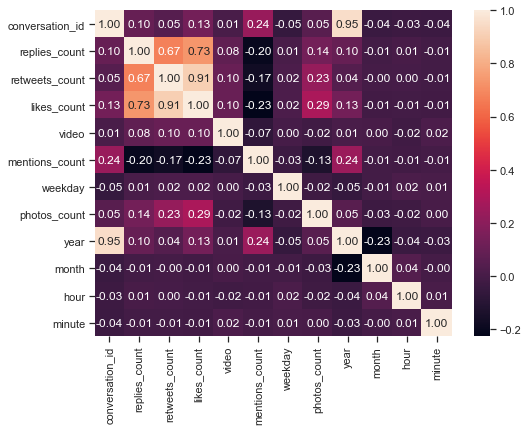

In [327]:
plt.subplots(figsize=(8,6))
sns.heatmap(new_df.corr(),  annot=True, fmt=".2f");

<h3> Plot with the seaborn library

In [253]:
# sns.set_theme(style="ticks")

# # Define the palette as a list to specify exact values
# palette = sns.color_palette("tab10", 5)

# # Plot the lines on two facets
# sns.relplot(
#     data=new_df,
#     x="weekday", y="likes_count",
#     hue="photos_count",# size="photos_count", col="likes_count",# size_order=["T1", "T2"],
#     kind="line",  palette=palette,
#     height=11, aspect=1.5, facet_kws=dict(sharex=False),
# )

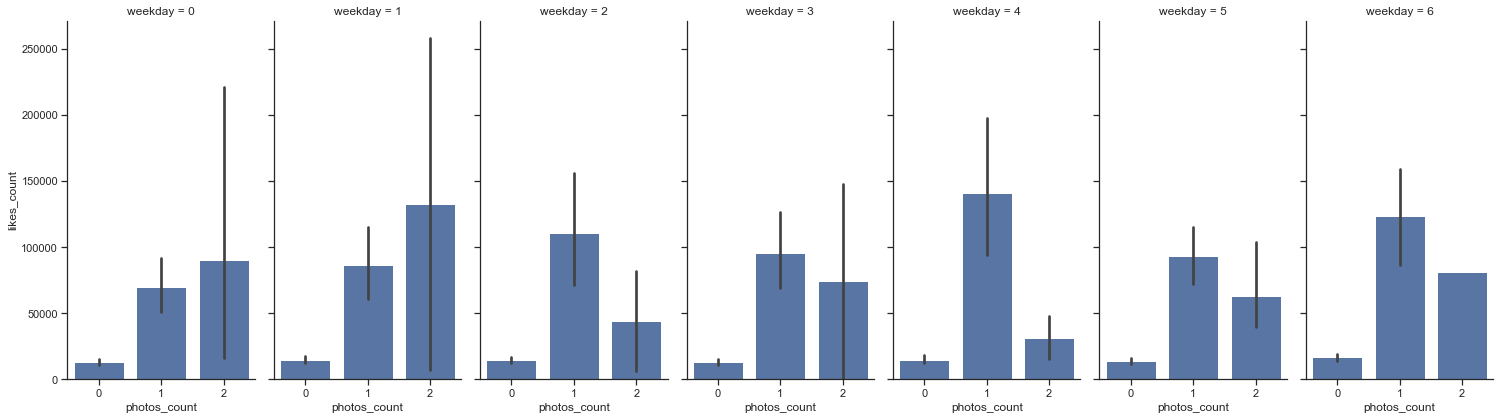

In [328]:
g = sns.FacetGrid(new_df, col="weekday", height=6, aspect=.5)
g.map(sns.barplot, "photos_count", "likes_count", order=[0, 1, 2])

<h4> We can see an interesting pattern on the figure above. Tweets with two photos, posted on Monday and Tuesday, will yield more likes than posted other days. Looks like tweets with one photo attached, will gain more response in likes posted from Wednesday till Sunday. Tweets with no photos will collect the lowest likes on average.

In [374]:
import altair as alt
alt.data_transformers.disable_max_rows()

base = alt.Chart(new_df, width=800, height=500).mark_point(filled=True).encode(
    x=alt.X('month:N'), y='likes_count:Q', tooltip=['tweet:N', 'likes_count:Q', 'photos_count:N']
)

# A slider filter
year_slider = alt.binding_range(min=2015, max=2020, step=1)
slider_selection = alt.selection_single(bind=year_slider, fields=['year'], name="Tweet")

rating_color_condition = alt.condition(slider_selection,
                      alt.Color('photos_count:N'),
                      alt.value('lightgray'))

filter_year = base.add_selection(
    slider_selection
).encode(
    color=rating_color_condition
).transform_filter(
    slider_selection
).properties(title="Slider Filtering")

filter_year

alt.Chart(...)

<h2> Text preprocessing

In [279]:
#Count the number of tweets
print(new_df.count())

conversation_id    9286
tweet              9286
replies_count      9286
retweets_count     9286
likes_count        9286
video              9286
mentions_count     9286
weekday            9286
photos_count       9286
datetime           9286
year               9286
hour               9286
minute             9286
dtype: int64


In [280]:
#Normalize the tweets to be lowercase
df['tweet'] = df['tweet'].str.lower()

In [281]:
#Drop duplicates tweets
new_df.drop_duplicates(subset=['tweet'], keep='first', inplace=True)
print(new_df.shape)
print(new_df.count())

(8356, 13)
conversation_id    8356
tweet              8356
replies_count      8356
retweets_count     8356
likes_count        8356
video              8356
mentions_count     8356
weekday            8356
photos_count       8356
datetime           8356
year               8356
hour               8356
minute             8356
dtype: int64


In [283]:
#Remove the @users
def remove_users(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
        
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

new_df['tidy_tweet'] = np.vectorize(remove_users)(new_df['tweet'], "@ [\w]*", "@[\w]*")

<h2> Descriptive statistics

In [284]:
#Count the number of characters and length of a tweet
count = new_df['tweet'].str.split().str.len()
count.index = count.index.astype(str) + ' words:'
count.sort_index(inplace=True)


def word_count(df):
    words_count = []
    for i, content in df['tweet'].items():
        new_values =[]
        new_values = content.split()
        words_count.append(len(new_values))
    df['word_count'] = words_count
    return df

new_df = word_count(new_df)

print("Total number of words: ", count.sum(), "words")

Total number of words:  112254 words


In [285]:
print("Average number of words per tweet: ", round(count.mean(),2), "words")
print("Max number of words per tweet: ", count.max(), "words")
print("Min number of words per tweet: ", count.min(), "words")

Average number of words per tweet:  13.43 words
Max number of words per tweet:  58 words
Min number of words per tweet:  1 words


In [286]:
new_df['tweet_length'] = new_df['tweet'].str.len()

print("Total length of a dataset: ", new_df.tweet_length.sum(), "characters")
print("Average length of a tweet: ", round(new_df.tweet_length.mean(),0), "characters")

Total length of a dataset:  705735 characters
Average length of a tweet:  84.0 characters


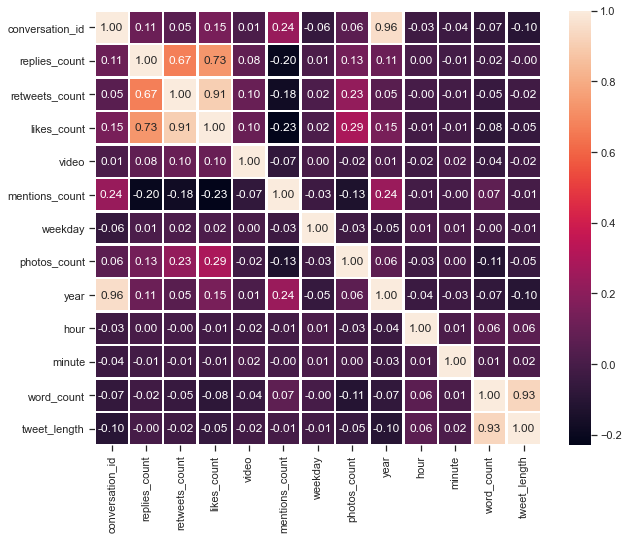

In [287]:
plt.subplots(figsize=(10,8))
sns.heatmap(new_df.corr(), annot=True, linewidths=1.5, fmt=".2f");

<b> From the correlation matrix above we can observe a few interesting correlations. Replies and retweets count are highly (73% and 91% respectively) positively correlated with the likes count. On the other hand, mentions count is moderately negatively (-23%) correlated with the likes count (the more mentions, the less likes). Attaching the photos or videos will likely increase the number of likes too (29% and 10% respectively). The length of a tweet is slightly negatively correlated with the likes count.

In [288]:
# print(new_df.columns)
X = new_df[['replies_count', 'retweets_count', 'mentions_count', 'weekday', 
            'photos_count', 'year', 'hour', 'minute', 'tweet_length','word_count'
           ]]
y = new_df[['likes_count']]

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:            likes_count   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     5506.
Date:                Wed, 30 Dec 2020   Prob (F-statistic):               0.00
Time:                        15:54:19   Log-Likelihood:                -95612.
No. Observations:                8356   AIC:                         1.912e+05
Df Residuals:                    8345   BIC:                         1.913e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -9.078e+06   3.94e+05    -23.

<b> From the table above, we can see the P>|t| value, which indicates if we can find an evidence of the statistical significance of each feature. When the value is ~<0.05, we could conclude that the feature has a statistial difference (statisticaly significant in other words). We can see that most of our features, but weekday, a minute, and a word count, are statistically significant for measureing the correlation between them and the target feature (likes count). Read more here: https://blog.minitab.com/blog/statistics-and-quality-data-analysis/what-are-t-values-and-p-values-in-statistics and here: https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression

In [376]:
alt.Chart(new_df, width=800, height=400
         ).mark_point(filled=True
                     ).encode(
    alt.X('hour:N', scale=alt.Scale(zero=True)),
    alt.Y('month:N', scale=alt.Scale(zero=True)),
    alt.Size('likes_count:Q'),
    #alt.Color('photos_count:N'),
    alt.OpacityValue(0.5),
    tooltip=['tweet:N', 'likes_count:Q', 'photos_count:N']
)

alt.Chart(...)

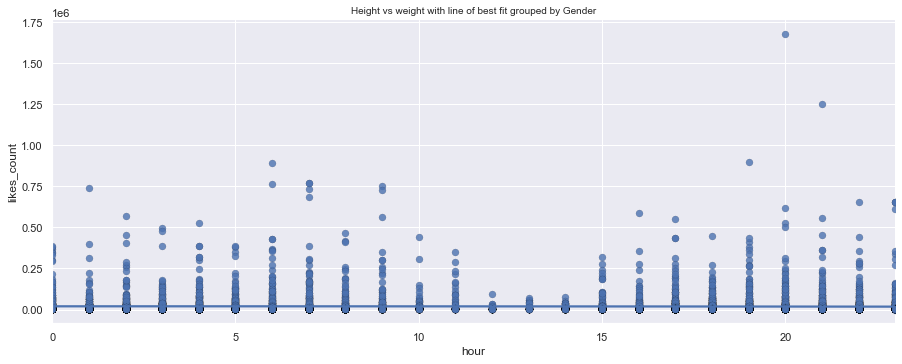

In [381]:
sns.set_theme(color_codes=True)
g = sns.lmplot(x='hour', y='likes_count', data = new_df,# col = 'photos_count', 
              aspect = 2.5, robust=False, palette='tab5',
              scatter_kws=dict(s=50, linewidths=.1, edgecolors='black'),
              order=2, ci=None
              )
plt.title("Height vs weight with line of best fit grouped by Gender", fontsize=10)
plt.show()

In [68]:
# import re
# hash_list = []
# for item in new_df['tweet']:
#     if re.search('^#.*', item):
#         hash.append(item)
# new_df['hash'] = hash_list

There weren't any hashtags in the dataset, wht indicates that it might have been removed by the dataset author.

<h2> Words analysis

In [289]:
def create_text_blob(df, text_column):
    blob_text=[]
    for i, content in df[text_column].items():
        for i in content.split():
            blob_text.append(i.lower())
    return blob_text

In [293]:
blob_text = create_text_blob(new_df, 'tidy_tweet')
print(blob_text[0:100])

['cute', 'wow', 'reusability', 'is', 'essential.', 'a', 'rocket', 'that', 'is', 'single', 'use', 'is', 'just', 'as', 'absurd', 'as', 'a', 'single', 'use', 'airplane.', 'f9', 'engines', 'already', 'fire', '3', 'times', 'per', 'flight.', 'wild', 'times!', 'we’re', 'being', 'extra', 'paranoid.', 'maximizing', 'probability', 'of', 'successful', 'launch', 'is', 'paramount.', 'welcome', 'anytime', 'well,', 'i', 'do', 'care', 'very', 'much', 'about', 'sustainability', 'of', 'civilization,', 'but', 'there', 'is', 'some', 'truth', 'to', 'the', 'irony', 'part', 'haha', 'yes,', 'in', 'plan.', 'superchargers', 'and', 'public', 'high', 'power', 'wall', 'connectors', 'will', 'keep', 'growing', 'exponentially', 'every', 'year.', '👀', 'i', 'think', 'so', 'doing', 'range', 'testing', 'now.', 'number', 'will', 'be', 'significantly', 'higher', 'than', '300.', 'extremely', 'good', 'for', 'any', 'ev,', 'especially']


In [256]:
from collections import Counter
# from textblob import Word

counts = Counter(blob_text)
print(counts)

Counter({'to': 2911, 'the': 2574, 'a': 2214, 'is': 2076, 'of': 1882, 'in': 1522, '&': 1457, 'for': 1301, '…': 1091, 'will': 1055, 'be': 1012, 'on': 933, 'that': 839, 'but': 825, 'it': 772, 'tesla': 747, 'this': 722, 'i': 710, 'with': 662, 'we': 641, 'are': 630, 'you': 569, 'not': 522, 'at': 519, 'and': 518, 'so': 497, 'as': 495, 'by': 460, 'have': 448, 'just': 389, 'or': 380, 'was': 366, 'all': 366, 'from': 366, 'if': 358, 'about': 340, 'an': 312, 'model': 303, 'no': 303, 'it’s': 297, 'like': 292, 'would': 285, 'more': 280, 'good': 273, 'my': 271, 'than': 270, 'should': 266, 'do': 256, 'can': 254, 'there': 248, 'has': 239, 'great': 223, 'car': 220, '3': 217, 'our': 216, 'they': 215, 'much': 205, 'only': 205, 'one': 203, 'what': 199, 'next': 197, 'make': 180, 'your': 180, 'high': 177, 'some': 176, 'get': 176, 'very': 174, 'which': 172, 'most': 170, 'even': 168, 'people': 162, 'need': 161, 'out': 159, 'probably': 158, 'up': 157, 'too': 153, 'when': 151, 'spacex': 151, 'many': 149, 'yes,'

In [257]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))  
filtered_sentence = [w for w in blob_text if not w in stop_words]  
filtered_sentence = []  
  
for w in blob_text:  
    if w not in stop_words:  
        filtered_sentence.append(w)  

print(filtered_sentence)  

['cute', 'wow', 'reusability', 'essential.', 'rocket', 'single', 'use', 'absurd', 'single', 'use', 'airplane.', 'f9', 'engines', 'already', 'fire', '3', 'times', 'per', 'flight.', 'wild', 'times!', 'we’re', 'extra', 'paranoid.', 'maximizing', 'probability', 'successful', 'launch', 'paramount.', 'welcome', 'anytime', 'well,', 'care', 'much', 'sustainability', 'civilization,', 'truth', 'irony', 'part', 'haha', 'yes,', 'plan.', 'superchargers', 'public', 'high', 'power', 'wall', 'connectors', 'keep', 'growing', 'exponentially', 'every', 'year.', '👀', 'think', 'range', 'testing', 'now.', 'number', 'significantly', 'higher', '300.', 'extremely', 'good', 'ev,', 'especially', 'suv.', 'reduced', 'pricing', 'model', 'lr', 'dual', 'motor', '&', 'offer', 'lr', 'single', 'motor', 'months,', 'improves', 'affordability,', 'still', 'keeping', 'product', 'excellent', 'yes', 'may', 'able', 'reach', '250kw', 'low', 'states', 'charge', 'no,', 'range', 'would', 'unacceptably', 'low', '(<', '250', 'mile', 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lukaszaszyk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [294]:
counts = Counter(filtered_sentence)
print(counts)
# for i, n in counts.items():
#     print(i,":", n)

Counter({'&': 1457, '…': 1091, 'tesla': 747, 'model': 303, 'it’s': 297, 'like': 292, 'would': 285, 'good': 273, 'great': 223, 'car': 220, '3': 217, 'much': 205, 'one': 203, 'next': 197, 'make': 180, 'high': 177, 'get': 176, 'even': 168, 'people': 162, 'need': 161, 'probably': 158, 'spacex': 151, 'many': 149, 'yes,': 148, 'new': 146, 'maybe': 139, 'rocket': 137, 'first': 137, 'don’t': 137, 'yeah,': 136, 'production': 134, 'cars': 133, 'that’s': 132, 'coming': 130, 'starship': 130, 'better': 129, 'work': 129, 'falcon': 129, 'actually': 124, 'time': 123, 'thanks': 120, 'way': 120, 'still': 119, 'think': 114, 'also': 114, 'love': 113, 'right': 113, 'us': 112, 'team': 111, 'lot': 111, 'almost': 111, 'really': 111, 'super': 110, 'launch': 109, 'going': 106, 'we’re': 104, 'could': 104, 'use': 103, 'best': 103, 'full': 96, 'you’re': 96, 'go': 95, 'year': 95, 'soon': 94, 'test': 93, 'autopilot': 93, 'mars': 92, 'working': 91, '2': 89, 'i’m': 89, 'years': 87, 'software': 87, 'hard': 86, 'heavy':

In [295]:
import plotly.express as px

top_20_words = {}

for (key, value) in counts.items():
   # Check if value is greater than 200 and add to new dictionary
    if value > 200 :
        top_20_words[key] = value
    continue

sorted_top_20_words = dict(sorted(top_20_words.items(), key=lambda item: item[1], reverse=False))

word = sorted_top_20_words.keys()
count = sorted_top_20_words.values()


fig = px.bar(y=word, x=count, text = count)
fig.update_traces(texttemplate='%{text:}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

As we can see on the graph above, there are a few insignificant words like '&', '...', or stopwords like "it's", "would" or numbers. We will get rid of them to get a clearer picture of what Elon Musk is tweeting about.

In [261]:
top_20_words_clean = {}

for (key, value) in counts.items():
    # Check if key length is greater than 3 and value greater than 150 and add to new dictionary
    if len(key)>2 and value > 150 :
        top_20_words_clean[key] = value
    continue

sorted_top_20_words_clean = dict(sorted(top_20_words_clean.items(), key=lambda item: item[1], reverse=False))

word = sorted_top_20_words_clean.keys()
count = sorted_top_20_words_clean.values()

fig = px.bar(y=word, x=count, text = count)
fig.update_traces(texttemplate='%{text:}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

Looks like Elon Musk was mostly tweeting about the tesla car model 3, and used nouns as like, good, great. We can see that SpaceX was alos occurring quite often.